#### **Step 1**: Load the Dataset

Load the MNIST dataset and inspect the data structure.

**Task:**

- Load the dataset using the provided data loader.
- Explore the dimensions of the training dataset.
---

#### **Step 2**: Preprocess the Data
Prepare the data for training by normalizing pixel values and converting data into tensors.

**Task:**

- Convert the dataset into PyTorch tensors.
- Normalize the pixel values to a range of -1 to 1. (mean =0.5, std = 0.5)
- Visualize a few sample images along with their labels.
--- 


Loading dataset: mnist...
MNIST dataset already downloaded
<class 'torch.Tensor'>
Image dimenstion: torch.Size([1, 28, 28])
Number of images in the 1st batch set: 64


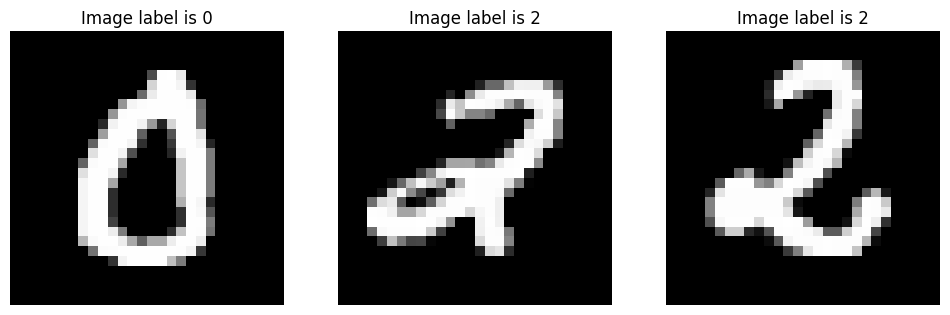

In [1]:
from utils import data_loader as dl
import torch
import numpy as np
import matplotlib.pyplot as plt

data_loader = dl.DataLoader()
mnist_trdata, mnist_testdata = data_loader.get_dataset("mnist")

trainloader = torch.utils.data.DataLoader(mnist_trdata, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(mnist_testdata, batch_size=64, shuffle=True)

dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(f"Image dimenstion: {images.shape[1:]}")
print(f"Number of images in the 1st batch set: {labels.shape[0]}")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))  
for k in range(3):
    axes[k].imshow(images[k].numpy().squeeze(), cmap='Greys_r')  
    axes[k].set_title(f"Image label is {labels[k]}")
    axes[k].axis('off')  


#### **Step 3**: Build the Neural Network
Define a neural network to classify the digits.

**Task:**

- Design a network architecture with 
    - **Input Layer**: 784 input units (corresponding to flattened 28x28 pixel images).
    - **First hidden layer** with 128 units.
    - **Second hidden layer** with 64 units.
    - **Output Layer**: - 10 units (corresponding to the 10 possible digit classes: 0–9).
-  Use **ReLU** (Rectified Linear Unit) for the two hidden layers to introduce non-linearity.
-  Use **Softmax** for the output layer to produce probabilities for each digit class.
- Create the neural network structure based on the above specifications and Initialize the model.
- Before training the model, test its forward pass using a single input image to verify that the network is functioning as expected.
- Visualize the the output using **helper module**.
--- 

The highest probablity 12.21% at class: 5


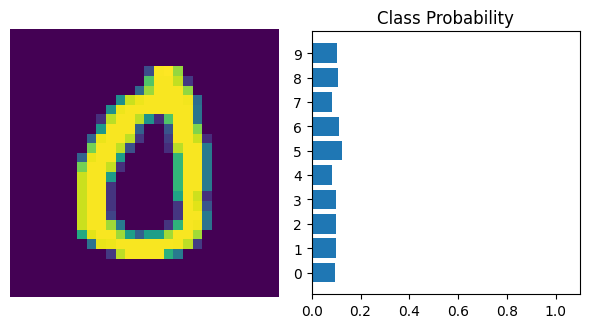

In [2]:
from torch import nn
from utils import view_helper

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))

# Test an image before training
images.resize_(images.shape[0], 1, 784)
img_idx = 0
ps = model.forward(images[img_idx,:])
img = images[img_idx]
view_helper.view_classify(img.view(1, 28, 28), ps)
print(f"The highest probablity {ps.topk(1).values.item()* 100:.2f}% at class: {ps.topk(1).indices.item()}")



#### **Step 4**: Define Loss Function and Optimizer
Set up a suitable loss function and optimizer to train the model.

**Task:**

- **Use Cross-Entropy Loss** as the loss function.
    - **Note**: `nn.CrossEntropyLoss()` is commonly used when the model outputs raw logits (i.e., before applying LogSoftmax). It internally applies Softmax and computes the negative log-likelihood loss.
    - **`nn.NLLLoss()`** is used when the model outputs log-probabilities (i.e., after applying LogSoftmax). It expects log-probabilities as inputs.

- **Select an optimizer**, such as SGD or Adam, and set the learning rate.
    - Example:
    ```python
    criterion = nn.CrossEntropyLoss()  # or nn.NLLLoss() if using LogSoftmax in the model
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    ```

In [3]:
from torch import optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#### **Step 5**: Train the Model
Train the neural network on the training dataset over multiple epochs.

**Task:**
- Loop through the training data for a specified number of epochs.
- In each epoch:
    - Perform a forward pass to compute the predictions.
    - Compute the loss for both training and testing.
    - Backpropagate the error and update the model weights.
    - Track the training/testing loss for each epoch.


In [4]:
epochs = 10
train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()        
        
        tot_train_loss += loss.item()
    else:
        tot_test_loss = 0
        test_correct = 0 
        with torch.no_grad():
            for images, labels in testloader:   
                images = images.view(images.shape[0], -1)         
                ps = model(images)
                loss = criterion(ps, labels)
                tot_test_loss += loss.item()

                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        

#### **Step 6**: Visualize Results
Visualize the model's performance using appropriate plots.

**Task:**

- Plot the training/testing loss curve over epochs.
- Display a sample image using **helper module** and print the actual and predicted labels.

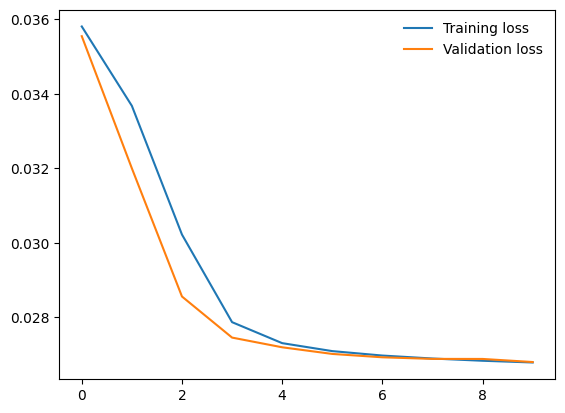

In [5]:
import matplotlib.pyplot as plt 

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

The highest probablity: 99.90% at class: 2


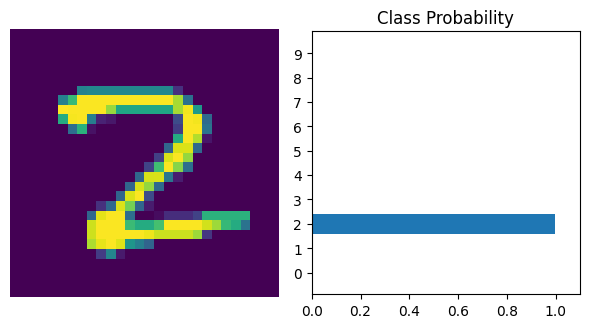

In [6]:
images, labels = next(iter(testloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    ps = model(img)

top_p, top_class = ps.topk(1, dim=1)

view_helper.view_classify(img.view(1, 28, 28), ps)
print(f"The highest probablity: {ps.topk(1).values.item()*100:.2f}% at class: {ps.topk(1).indices.item()}")


#### **Step 7**: Evaluate the Model
Assess the model's performance on the testing dataset.
**Task:**
- Perform predictions on the test dataset.
- Generate a confusion matrix to analyze classification errors.
- Calculate accuracy by comparing predicted labels with actual labels.

---

In [7]:
import pandas as pd

model.eval()
pred_class = []
actual_class = []
with torch.no_grad():
    for images, labels in testloader:   
        images = images.view(images.shape[0], -1)         
        ps = model(images)
        loss = criterion(ps, labels)

        top_p, top_class = ps.topk(1, dim=1)
        pred_class.extend(top_class.numpy())
        actual_class.extend(labels.numpy())

pred_class = np.array(pred_class).flatten() 
actual_class = np.array(actual_class).flatten()               


In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

class_labels = pd.DataFrame({'Predicted': pred_class, 'Truth_Label': actual_class})
class_counts = class_labels['Truth_Label'].value_counts().sort_index()
cm = confusion_matrix(actual_class, pred_class)

print("Confusion Matrix:")
print(cm)

TP = np.diag(cm)  
FP = np.sum(cm, axis=0) - TP  
FN = np.sum(cm, axis=1) - TP  

result_df = pd.DataFrame({"True Positive": TP, "False Positive": FP, "False Negative": FN, "Number_Samples": class_counts.values})
print(f"Accuracy of the model is: {result_df['True Positive'].sum()/len(class_labels):0.2f}")



Confusion Matrix:
[[ 959    0    1    2    0    0   11    2    5    0]
 [   0 1106    3    4    0    0    5    2   15    0]
 [  14    4  911   15    0    0   29   14   34   11]
 [   3    0   24  935    0    0    6   21   18    3]
 [   2    2    6    0    0    0   79    3   36  854]
 [  83   11   17  284    0    0   51   54  346   46]
 [  10    3    3    3    0    0  932    1    5    1]
 [   5   12   26    3    0    0    0  943    4   35]
 [   5    9    6   26    0    0   21   11  883   13]
 [  14    7    3   16    0    0    3   19   14  933]]
Accuracy of the model is: 0.76


#### **Step 8**: Save the Model

**Task:**
- Save the trained model using PyTorch's `torch.save()` function.
- Ensure the model state dictionary (**model.state_dict()**) is saved, as it contains the model parameters.

---

In [9]:
checkpoint = {
    'input_size': input_size,  
    'output_size': output_size,  
    'hidden_layers': hidden_sizes,  
    'state_dict': model.state_dict()  
}

model_path = f"./models/digit_classifier_model.pth"
torch.save(checkpoint, model_path)